In [1]:
import timm
from fastai.vision.all import *

dk_dir = Path("image_preproc")
fin_dir = Path("finland_bugs")

model_dir = Path("models")

img_size = 300

/home/kenneth/anaconda3/envs/fastai/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(len(get_image_files(dk_dir)))
print(len(get_image_files(fin_dir)))


3478
15074


In [4]:
targets = [parent_label(i) for i in get_image_files(dk_dir)]
count = Counter(targets)
wgts = [1/count[i] for i in targets]

dk_db = DataBlock(blocks = (ImageBlock,CategoryBlock),
                  get_items = get_image_files,
                  splitter = GrandparentSplitter(),
                  item_tfms=Resize(360, method=ResizeMethod.Crop), 
                  batch_tfms=aug_transforms(mult=1, size=img_size, min_scale=0.5, flip_vert=True),
                  get_y = parent_label)
dk_dl = dk_db.weighted_dataloaders(dk_dir, wgts=wgts, bs=32)

In [5]:
n_classes = len(dk_dl.vocab)

In [6]:
#dk_dl.show_batch()

In [9]:
#train learner using ept dataset
learn = vision_learner(dk_dl, 
                       "efficientnet_b0",
                       pretrained=True,
                       normalize=True,
                       #cbs=[MixUp()],
                       loss_func=LabelSmoothingCrossEntropy(),
                       metrics=[accuracy, top_k_accuracy]).to_fp16()

In [10]:
learn.fine_tune(epochs=25, freeze_epochs=2)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.553790,1.573483,0.741333,0.946667,00:13
1,1.820162,1.421216,0.768000,0.962667,00:13


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.466120,1.329087,0.784000,0.973333,00:15
1,1.436738,1.263254,0.813333,0.976000,00:15
2,1.377762,1.223928,0.829333,0.976000,00:15
3,1.322878,1.182950,0.818667,0.978667,00:15
4,1.255942,1.148135,0.829333,0.981333,00:15
5,1.219432,1.144843,0.829333,0.981333,00:15
6,1.171436,1.121696,0.818667,0.986667,00:15
7,1.148883,1.103491,0.826667,0.981333,00:15
8,1.113785,1.071645,0.848000,0.986667,00:15
9,1.101583,1.055205,0.861333,0.984000,00:15


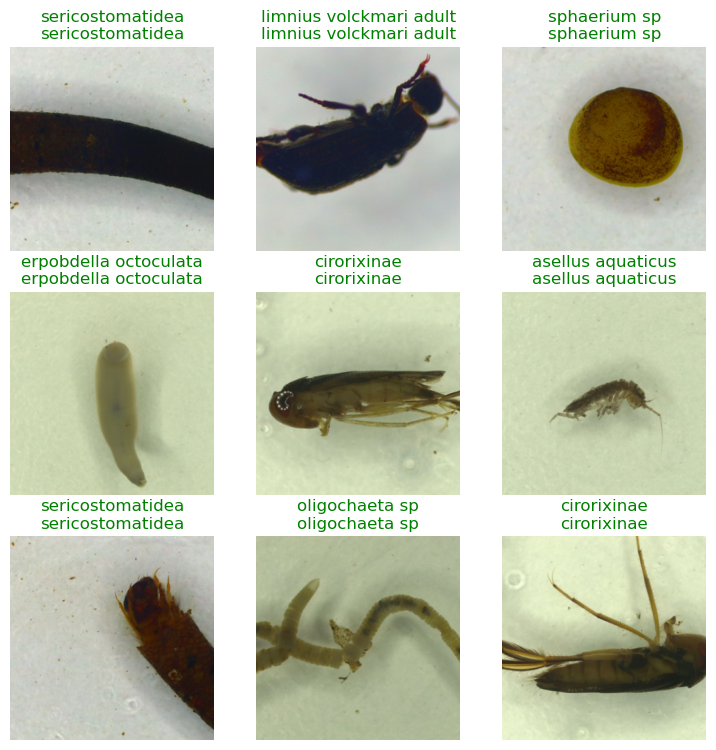

In [11]:
learn.show_results()

In [12]:
interpreter = ClassificationInterpretation.from_learner(learn)

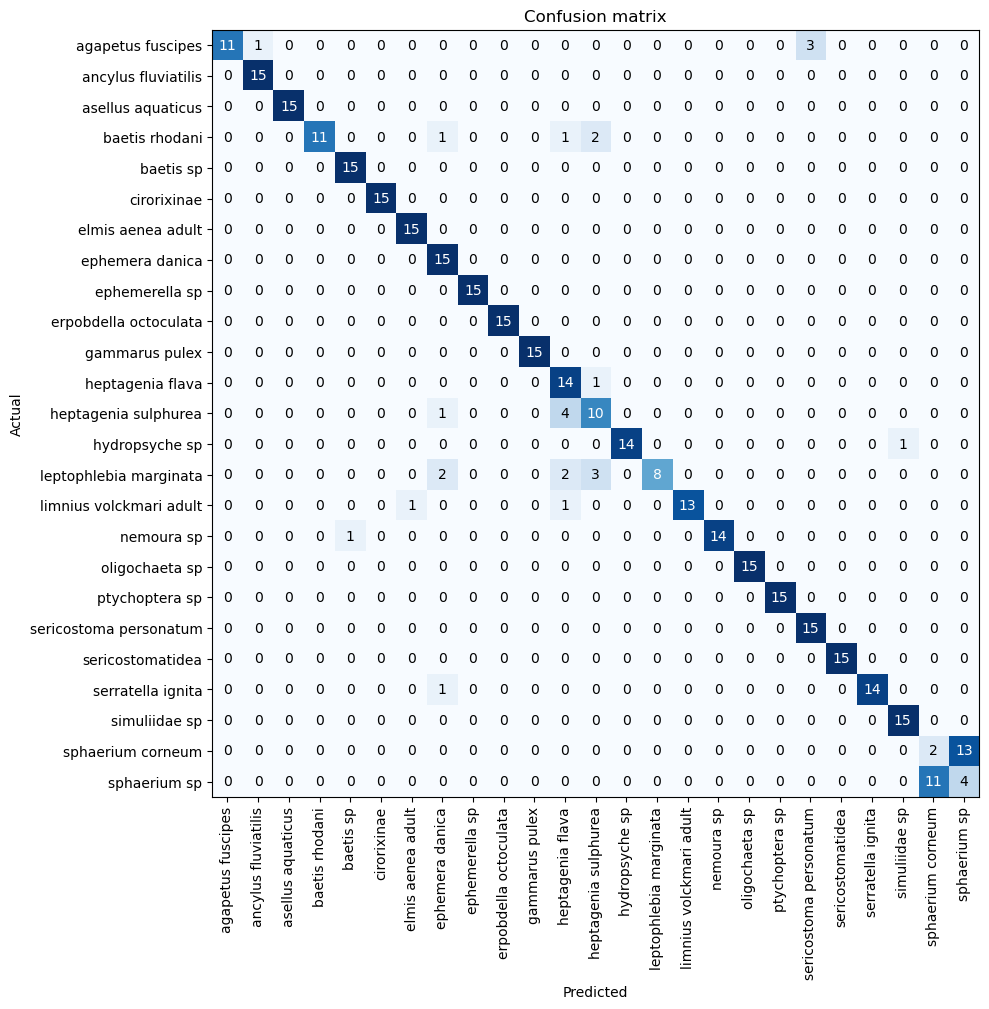

In [17]:
interpreter.plot_confusion_matrix(figsize=(10,10))

In [18]:
#save model
learn.path = model_dir
learn.export("effnet_b0.export")

In [19]:
vocab = learn.dls.vocab

with open(model_dir/"dk_vocab.txt", 'w') as f:
    f.write('\n'.join(vocab))

In [20]:
model_conf = timm.create_model("efficientnet_b0", pretrained=True,num_classes = n_classes).default_cfg

In [21]:
model_conf

{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth',
 'num_classes': 1000,
 'input_size': (3, 224, 224),
 'pool_size': (7, 7),
 'crop_pct': 0.875,
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'first_conv': 'conv_stem',
 'classifier': 'classifier',
 'architecture': 'efficientnet_b0'}

In [22]:
from torchvision import transforms

#define normalization layer
normalization_layer = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

torch_model = learn.model.cpu()

#define softmax layer
softmax_layer = torch.nn.Softmax(dim=-1) 

#assemble the final model
final_model = nn.Sequential(normalization_layer, torch_model, softmax_layer)

In [23]:
# generate model input
dummy_input = torch.randn(1, 3, img_size, img_size, requires_grad=True)

onnx_model_path = model_dir/"effnet_b0.onnx"


In [24]:
#https://docs.opencv.org/4.x/dc/d70/pytorch_cls_tutorial_dnn_conversion.html
#model export into ONNX format
torch.onnx.export(
    final_model,
    dummy_input,
    onnx_model_path,
    export_params=True,
    #opset_version=11,
    do_constant_folding=True,
    input_names = ['input'],
    output_names = ['output']
)

In [79]:
#quantize model??
import onnx
#from onnxruntime.quantization import quantize_dynamic, QuantType, quant_pre_process

model_fp32 = 'models/effnet_b0.onnx'

#model_pre = 'models/effnet_b0_preproc.onnx'
#quant_pre_process(model_fp32, model_pre)

#model_quant = 'models/effnet_b0_quant.onnx'
#quantize_dynamic(model_pre, model_quant, weight_type=QuantType.QUInt8, optimize_model=False)

In [80]:
#fastai validation preds
inputs, preds, y, cls = learn.get_preds(with_decoded=True, with_input=True)

In [81]:
(cls.numpy() == y.numpy()).mean()

0.8666666666666667

In [82]:
#test onnxruntime quantized models
import onnxruntime as ort
import PIL
from PIL import Image, ImageOps

ort_sess = ort.InferenceSession(model_quant)
#ort_sess_quant = ort.InferenceSession(model_quant)

valid_imgs = get_image_files(dk_dir/"valid")


In [83]:
onnx_preds = []

for i in valid_imgs:
    
    image = Image.open(i)
    
    img_h, img_w = image.shape
    
    if img_h > img_w:
        new_h = int(img_size * (img_h/img_w))
        new_w = img_size
    else:
        new_h = img_size 
        new_w = int(img_size / (img_h/img_w))
        
    image_resize = image.resize((new_w, new_h), resample=PIL.Image.Resampling.BILINEAR)
    
    cw, ch = img_size, img_size
    h, w = image_resize.shape
    wdif, hdif = (w-cw)//2, (h-ch)//2
    border = wdif, hdif, wdif, hdif
    cropped_img = ImageOps.crop(image_resize, border)
    
    image_np = np.array(cropped_img)[:300,:300,0:3]
    image_np = np.transpose(image_np, (2, 0, 1))
    image_np = np.expand_dims(image_np, axis=0)
    image_np = (image_np/255.0).astype("float32")
    
    outputs = ort_sess.run(None, {'input': image_np})

    ind = np.argmax(outputs[0])
    ind_probs = outputs[0][0][ind]
    onnx_preds.append(ind)

In [84]:
onnx_preds_np = np.array(onnx_preds)
(onnx_preds_np == y.numpy()).mean()

0.037333333333333336

In [85]:
(onnx_preds_np == cls.numpy()).mean()

0.042666666666666665

In [86]:
from matplotlib import pyplot as plt


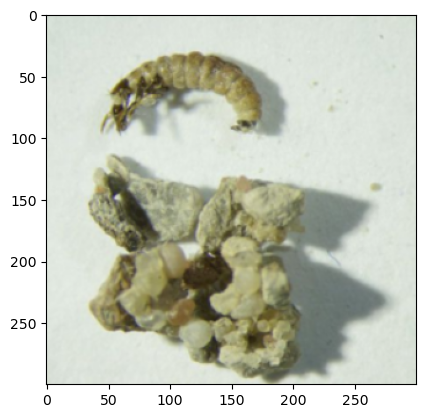

In [87]:
#manual preproc image
plt.imshow(np.transpose(image_np.squeeze(), (1, 2, 0)))

In [88]:
#fastai image

In [89]:
fastai_img = np.transpose(inputs[-1].numpy(), (1, 2, 0)) * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])

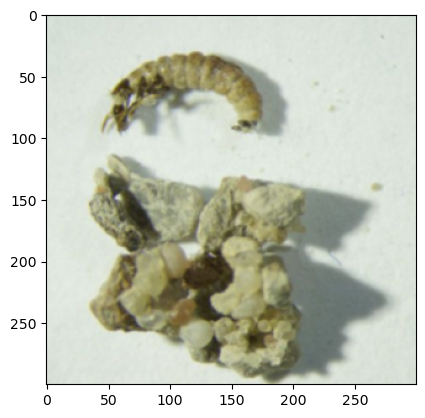

In [90]:
plt.imshow(fastai_img)

In [37]:
#test fastai preds vs opencv (gui version)

In [12]:
import cv2

tmp="dk_bugs_preproc/Erpobdella octoculato/Erpobdella octoculato002.jpg"

model_vocab = []
with open("models/dk_vocab.txt", 'r') as f:
    for i in f:
        x = i[:-1]
        model_vocab.append(x)

In [13]:
#load fastai model
learn = load_learner(model_dir/"effnet_b3.export")

In [14]:
pred, pred_idx, probs = learn.predict(tmp)
print(pred)
print(pred_idx)
print(probs)

Erpobdella octoculato
TensorBase(6)
TensorBase([3.7876e-03, 1.4055e-03, 1.0654e-03, 2.7079e-03, 1.5490e-03,
            1.4937e-03, 9.6794e-01, 7.3084e-04, 5.5927e-04, 5.0436e-04,
            4.8122e-04, 9.2180e-04, 3.6048e-04, 8.2964e-04, 1.6066e-03,
            3.4049e-04, 4.5307e-04, 3.0887e-03, 7.1304e-04, 7.5050e-04,
            1.4992e-03, 5.4788e-04, 4.5340e-04, 4.4914e-03, 5.9152e-04,
            1.9840e-04, 9.3153e-04])


In [15]:
img = cv2.imread(tmp)

In [16]:
model_path = "models/effnet_b3.onnx"
model = cv2.dnn.readNetFromONNX(model_path)

In [18]:
model_input = cv2.dnn.blobFromImage(
                image = img,
                scalefactor = 1.0/255.0,
                size = (images_size, images_size),
                swapRB=True,
                crop=True)  

In [19]:
model.setInput(model_input)
out = model.forward().squeeze()
idx_pred = np.argmax(out)
class_pred = model_vocab[idx_pred]

In [20]:
list(out)

[0.0050482512,
 0.0017537953,
 0.00058457366,
 0.0044957036,
 0.0013976505,
 0.00153644,
 0.9664932,
 0.00068233715,
 0.00044065437,
 0.00039609906,
 0.0010620565,
 0.000716919,
 0.00043023488,
 0.00074653537,
 0.0019502399,
 0.0004926067,
 0.00051821553,
 0.0019159592,
 0.0006240619,
 0.00077295554,
 0.0011219404,
 0.00042835445,
 0.0005313849,
 0.0036684624,
 0.00096661056,
 0.00019896541,
 0.0010257751]

In [21]:
list(probs)

[TensorBase(0.0038),
 TensorBase(0.0014),
 TensorBase(0.0011),
 TensorBase(0.0027),
 TensorBase(0.0015),
 TensorBase(0.0015),
 TensorBase(0.9679),
 TensorBase(0.0007),
 TensorBase(0.0006),
 TensorBase(0.0005),
 TensorBase(0.0005),
 TensorBase(0.0009),
 TensorBase(0.0004),
 TensorBase(0.0008),
 TensorBase(0.0016),
 TensorBase(0.0003),
 TensorBase(0.0005),
 TensorBase(0.0031),
 TensorBase(0.0007),
 TensorBase(0.0008),
 TensorBase(0.0015),
 TensorBase(0.0005),
 TensorBase(0.0005),
 TensorBase(0.0045),
 TensorBase(0.0006),
 TensorBase(0.0002),
 TensorBase(0.0009)]